In [1]:
using Revise 
using EuclidianNormalizingFlows

using BAT
using Distributions
using Optimisers
using FunctionChains
using ArraysOfArrays
using LinearAlgebra
using ValueShapes
using StatsBase
using FileIO
using JLD2
using CUDA
using CUDAKernels
using KernelAbstractions
using Flux
using PyPlot

n_smpls = 10^5
n_dims = 2
n_modes = 10

mvns = [MvNormal(10 .*rand(n_dims), 0.5 * abs(randn(1)[1]) .* I(n_dims)) for i in 1:n_modes]
d = MixtureModel(mvns)
importance_density = MvNormal(zeros(n_dims), I)
wanna_use_GPU = true
_device = wanna_use_GPU ? KernelAbstractions.get_device(CUDA.rand(10)) : KernelAbstractions.get_device(rand(10))
samples = bat_sample(d, BAT.IIDSampling(nsamples=n_smpls)).result;
smpls_flat = flatview(unshaped.(samples.v));
samples_nested = wanna_use_GPU ? nestedview(gpu(smpls_flat)) : nestedview(smpls_flat);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44


In [2]:
nbatches = 10
nepochs = 100
K = 40

blocks = get_flow_musketeer(n_dims,_device,K)
#lr=range(5f-3, 5f-4, length=length(blocks.fs))
lr = fill(3f-3, length(blocks.fs))
trained_blocks = Function[ScaleShiftNorm(_device)]
hists = Vector[]
#smpls_transformed = samples_nested;
smpls_train = samples_nested;

@time begin
    #smpls_train = nestedview(smpls_flat)
    smpls_train = nestedview(trained_blocks[1](smpls_flat))
    
    
    for i in 1:n_dims#Int(n_dims/2)#length(blocks.fs)
        #println("+++ Starting round $i")
        #nbatches= round(Int,nbatches * 1.16)
            
        if i%50==0 
            println("+++ Starting round $i")
        end
        
        r = optimize_whitening(smpls_train, 
            blocks.fs[1+i],
            Optimisers.Adam(lr[i]),
            nbatches=nbatches,
            nepochs=nepochs, 
            shuffle_samples =false)
            
        trained_trafo = r.result
        push!(trained_blocks, trained_trafo)
        push!(hists, r.negll_history)
        smpls_train = nestedview(trained_trafo(flatview(smpls_train)))
    end
end

push!(trained_blocks, ScaleShiftNorm(_device))
trained_flow = fchain(trained_blocks)
smpls_transformed, ladj_trafo = EuclidianNormalizingFlows.with_logabsdet_jacobian(trained_flow, smpls_flat)

smpls_transformed = cpu(smpls_transformed)
smpls_flat_cpu = cpu(smpls_flat)

ghm_integral, ghm_variance = ghm_integration(smpls_transformed, samples.logd, vec(cpu(ladj_trafo)), importance_density)

@show ghm_integral
@show ghm_variance


fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[1].hist2d(smpls_flat_cpu[1,:], smpls_flat_cpu[2,:], [100,100], cmap="inferno")
ax[1].set_xlim([minimum(smpls_flat_cpu[1,:]), maximum(smpls_flat_cpu[1,:])])
ax[1].set_ylim([minimum(smpls_flat_cpu[2,:]), maximum(smpls_flat_cpu[2,:])])
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [100,100], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])


target_density = BAT.Transformed(convert(BAT.AbstractMeasureOrDensity, BAT.StandardMvNormal(n_dims)), trained_flow, BAT.TDNoCorr())
target_samples = DensitySampleVector(nestedview(smpls_flat), samples.logd - vec(cpu(ladj_trafo)))
proposal_density = convert(BAT.AbstractMeasureOrDensity, BAT.StandardMvNormal(n_dims))
proposal_samples = bat_sample(proposal_density, BAT.IIDSampling(nsamples=n_smpls)).result


bs_integral = BAT.bridge_sampling_integral(target_density,
                                           target_samples, 
                                           proposal_density,
                                           proposal_samples,
                                           false)
@show bs_integral


145.446417 seconds (298.70 M allocations: 72.444 GiB, 5.41% gc time, 59.67% compilation time: 0% of which was recompilation)
ghm_integral = 0.9849715629742269
ghm_variance = 0.00042459240410178155


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/ACS/BAT.jl/src/algotypes/bat_default.jl:44


LoadError: DomainError with Need to implement inverse of ScaleShiftNorm:


In [51]:
save("Nice_MvN_200D_musketeer_23mar21st.jld2", 
    Dict(
    "int" => integral, 
    "int_var" => variance, 
    "flow" => cpu(trained_flow),
    "samples" => cpu(samples),
    "target_dist" => d,
    "nbatches" => nbatches,
    "nepochs" => nepochs,
    "K" => K,
    "lr" => lr,
    "neg_ll_hists" => hists,
    #"trained_blocks" => trained_blocks
    )
)

In [3]:
ts_mean = vec(mean(smpls_transformed,dims=2))
ts_cov = cov(smpls_transformed,dims = 2)

target_samples = DensitySampleVector(nestedview(smpls_transformed), log_posterior)

proposal_density = convert(BAT.AbstractMeasureOrDensity,MvNormal(ts_mean, ts_cov))
target_density = BAT.Transformed(proposal_density, cpu(trained_flow), BAT.TDLADJCorr())
proposal_samples = bat_sample(proposal_density, BAT.IIDSampling(nsamples=n_smpls)).result

bridge_int = BAT.bridge_sampling_integral(target_density, target_samples, proposal_density, proposal_samples, false)

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/iwsatlas1/mdud/BAT.jl/src/algotypes/bat_default.jl:44


0.0802 ± 0.0013

In [ ]:
v_orig, ladj = BAT._v_orig_and_ladj(target_density, proposal_samples.v[1])
logd_orig = BAT.logdensityof(parent(target_density), v_orig)

In [12]:
x = randn(4,10)
ladj = 1
fill(ladj, (size(x, 2),))'

1×10 adjoint(::Vector{Int64}) with eltype Int64:
 1  1  1  1  1  1  1  1  1  1

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


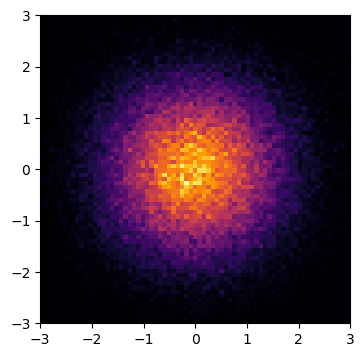

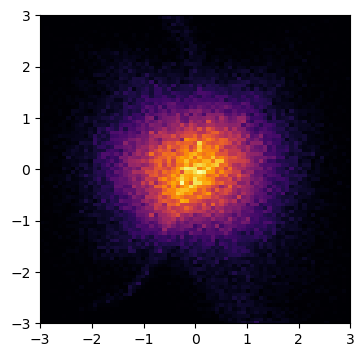

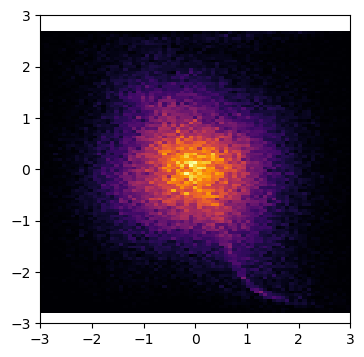

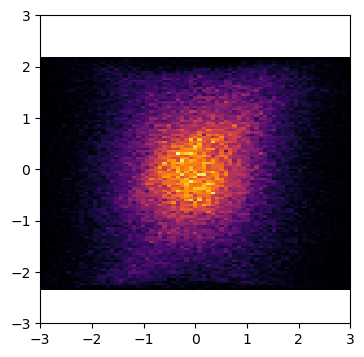

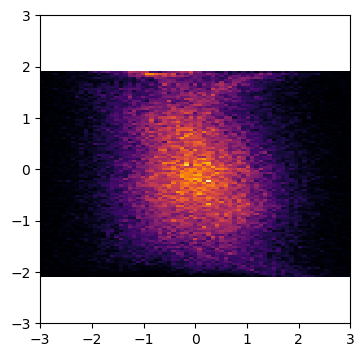

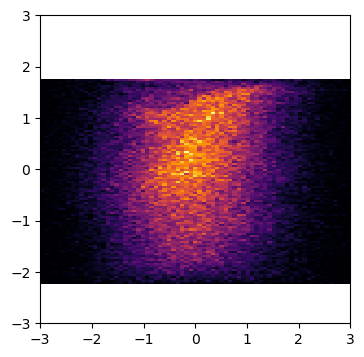

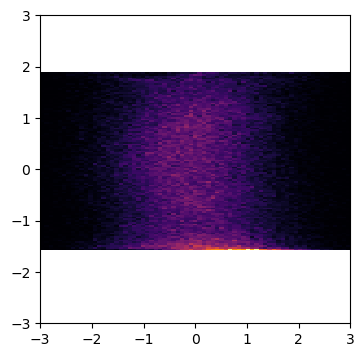

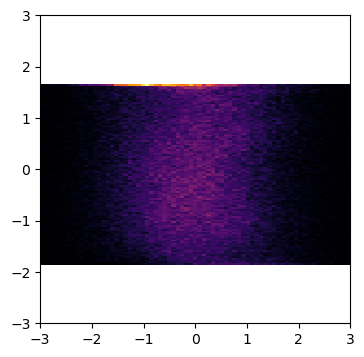

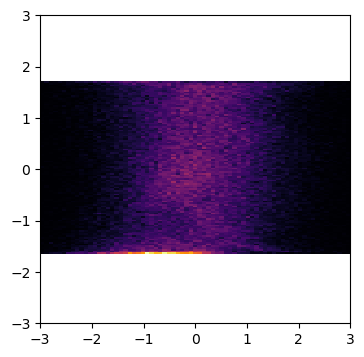

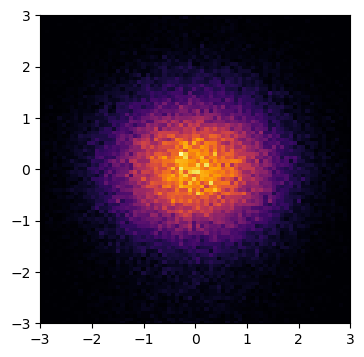

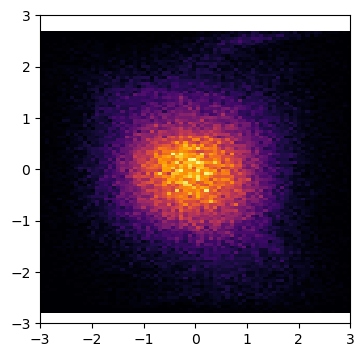

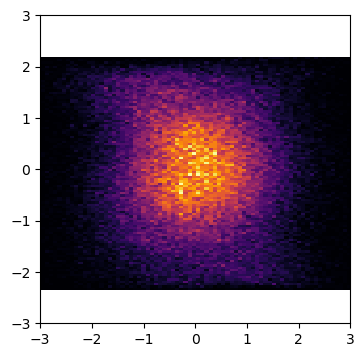

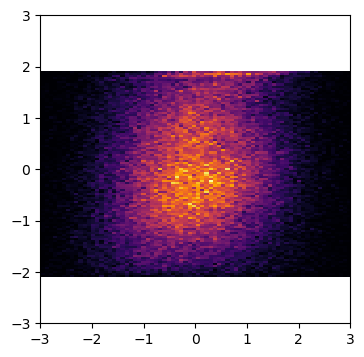

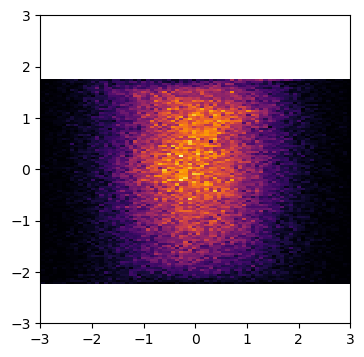

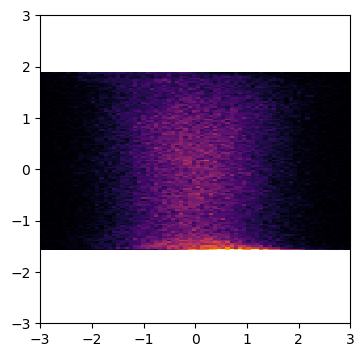

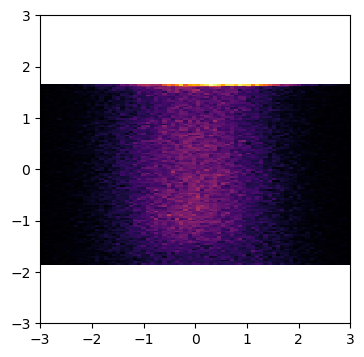

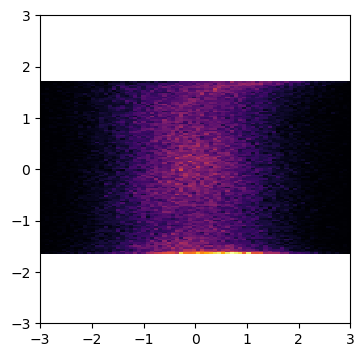

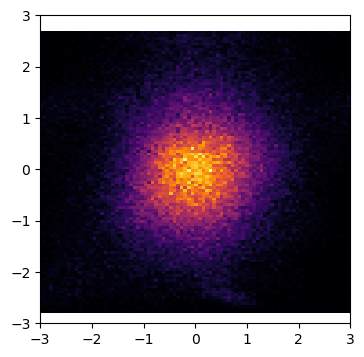

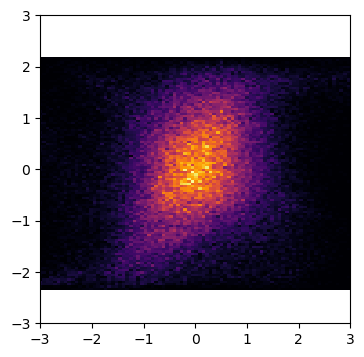

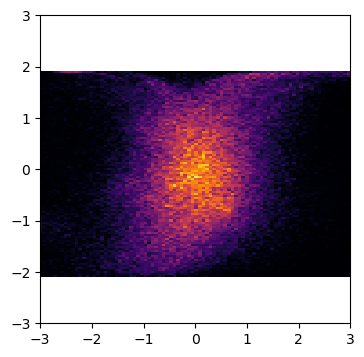

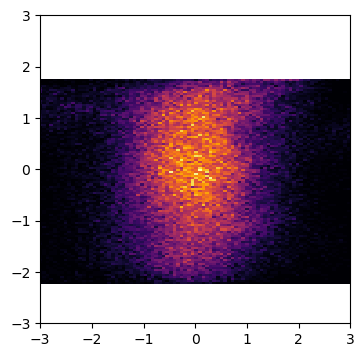

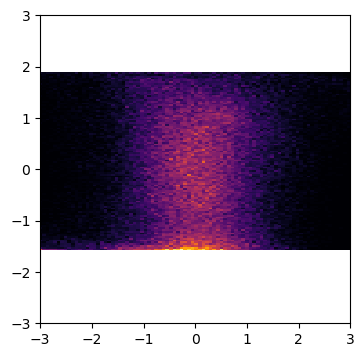

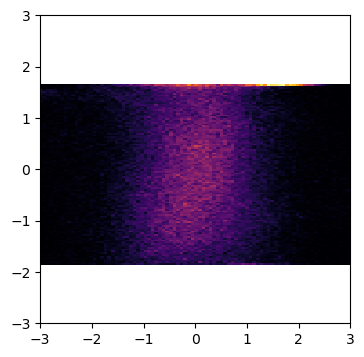

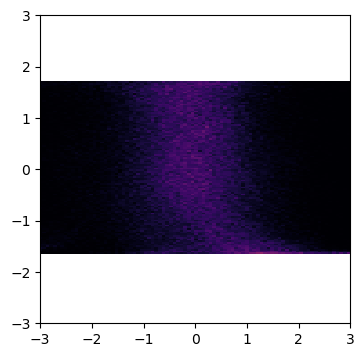

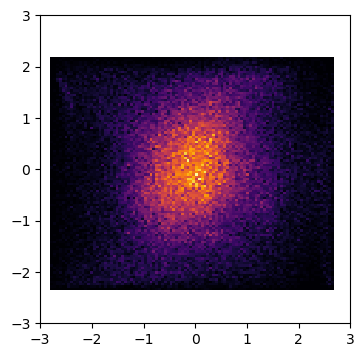

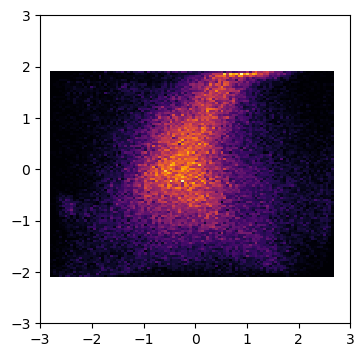

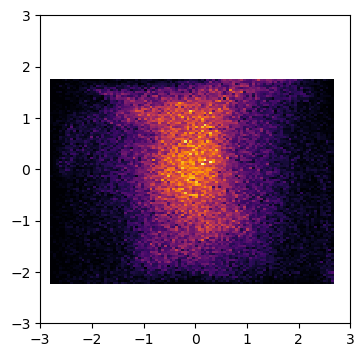

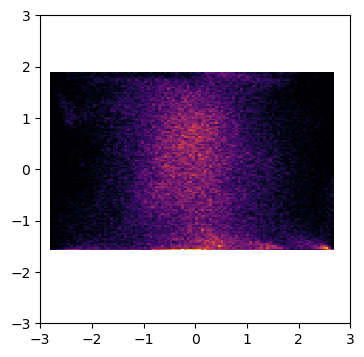

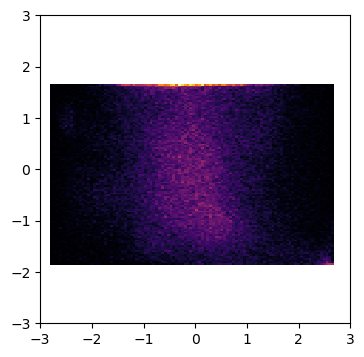

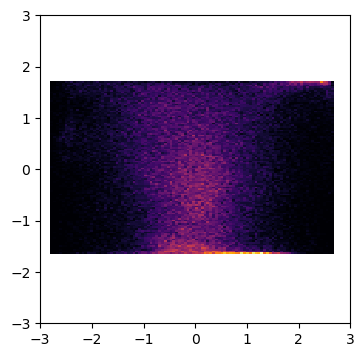

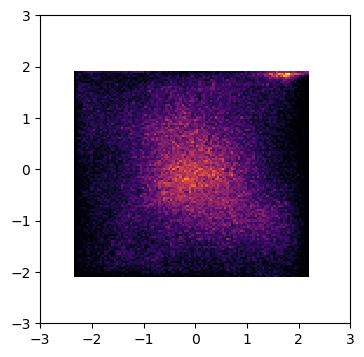

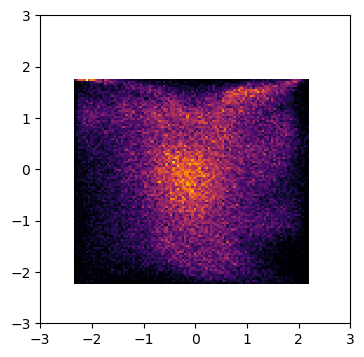

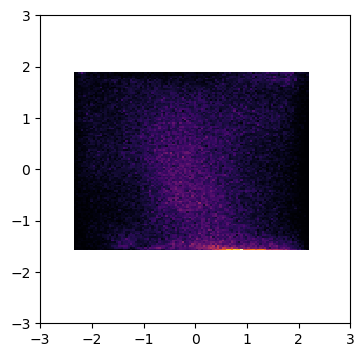

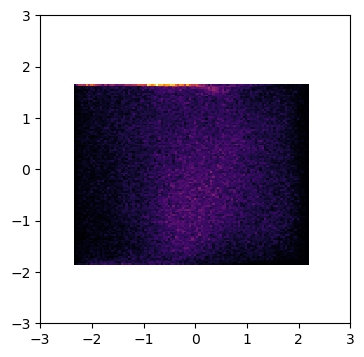

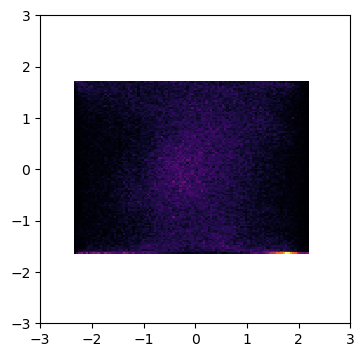

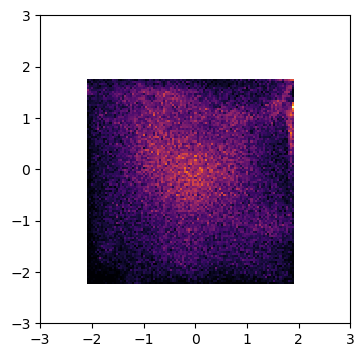

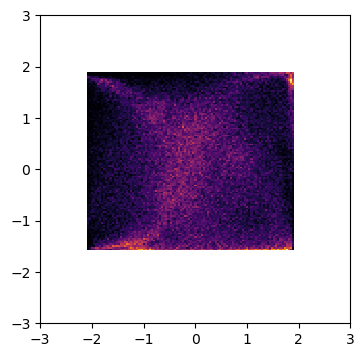

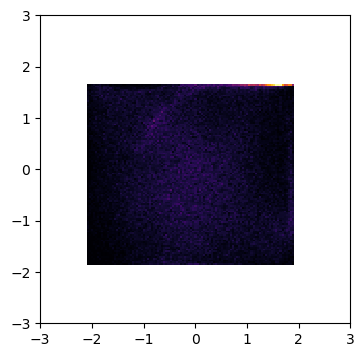

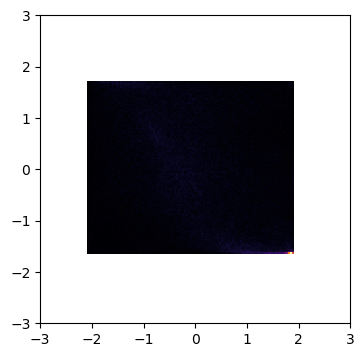

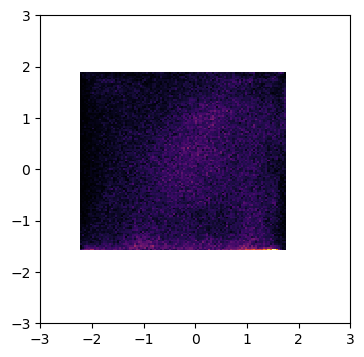

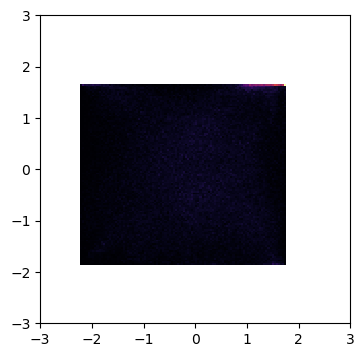

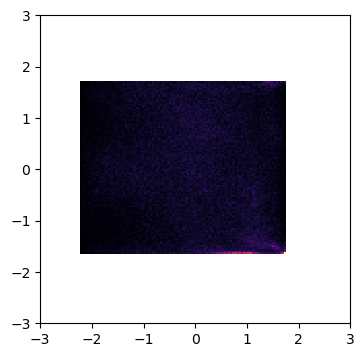

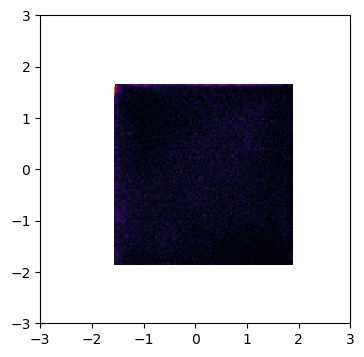

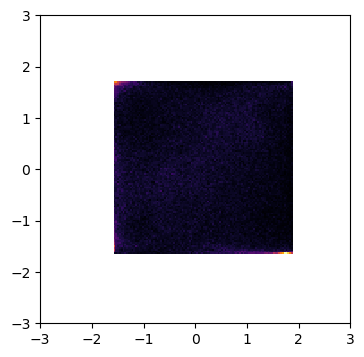

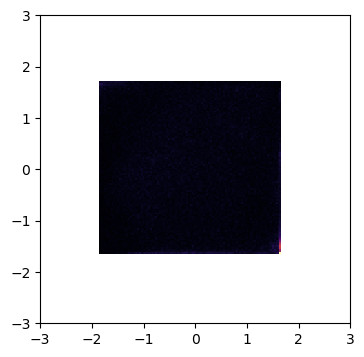

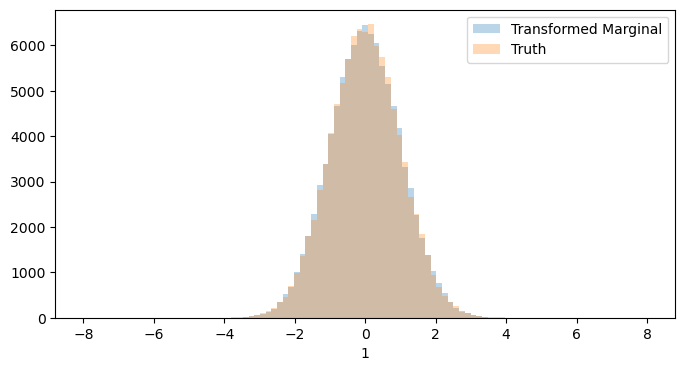

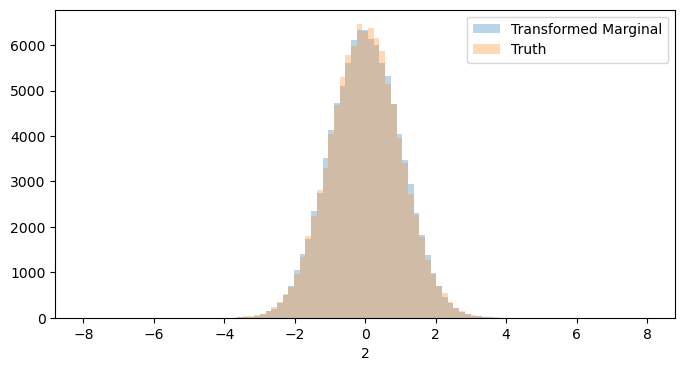

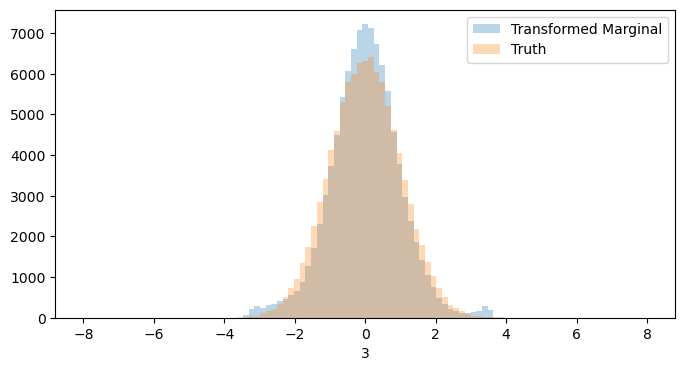

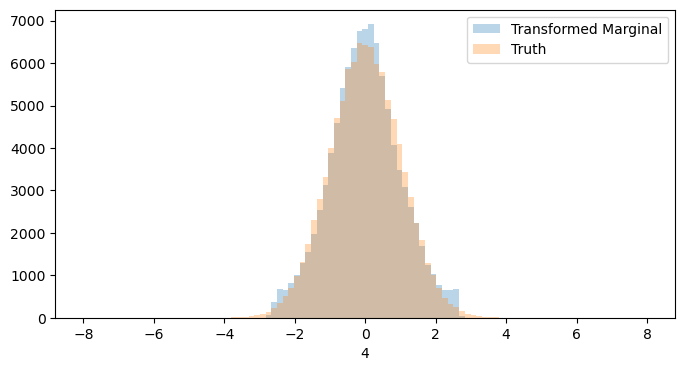

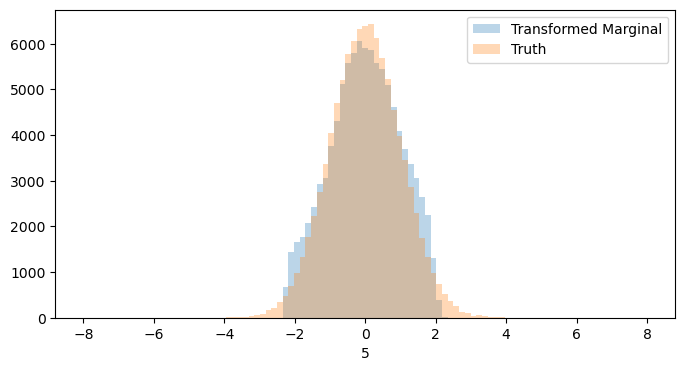

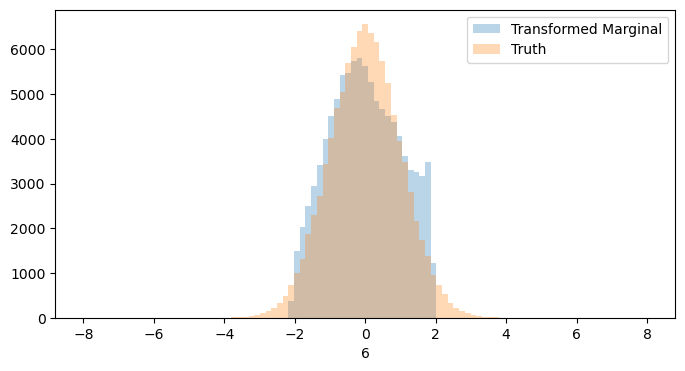

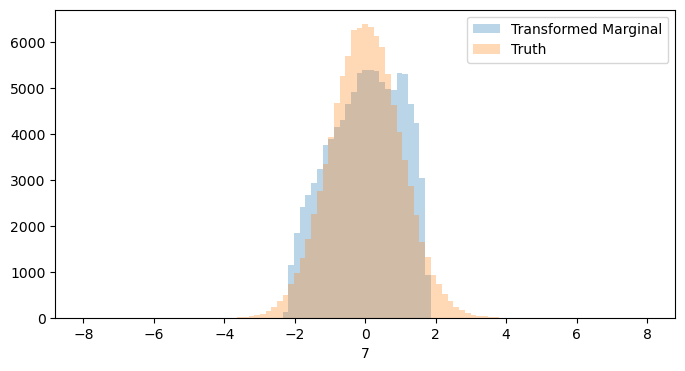

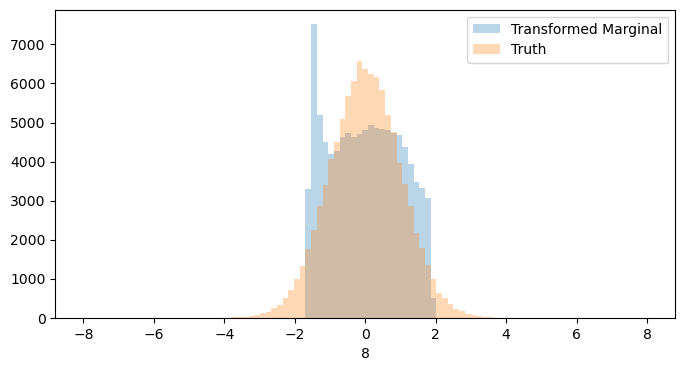

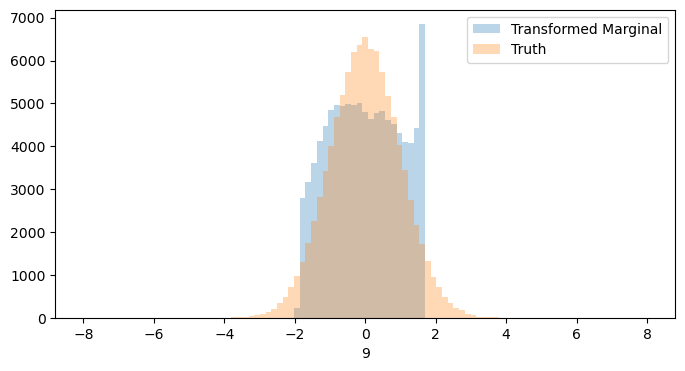

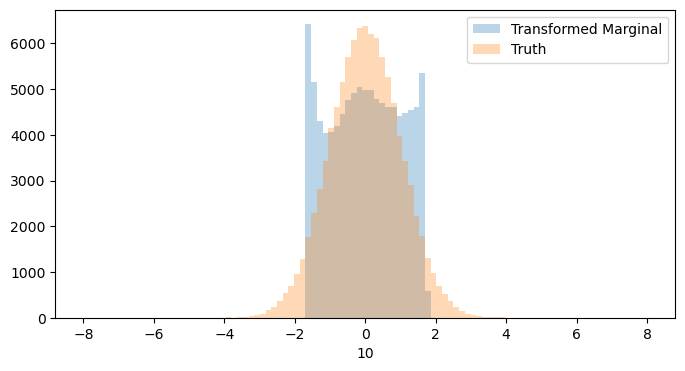

In [100]:
partners = [[i:n_dims...] for i in 2:n_dims]

for (j,partner) in enumerate(partners) 
    for i in partner

        fig, ax = plt.subplots(1,1, figsize=(4,4))
        ax.hist2d(smpls_transformed[j,:], smpls_transformed[i,:], [100,100], cmap="inferno")
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])

    end
end


for i in 1:size(smpls_flat,1)
    fig, ax = plt.subplots(1, figsize=(8,4))
    bins = range(-8, 8, 100)
    ax.hist(smpls_transformed[i,:], weights=fill(1,size(smpls_transformed,2)), bins=bins, alpha=0.3, label="Transformed Marginal")
    ax.hist(rand(Normal(), n_smpls),  bins=bins, alpha=0.3, label="Truth")
    ax.legend()
    ax.set_xlabel("$i")
end

In [ ]:
for i in 1:length(hists)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists[i]), hists[i])
end


In [ ]:


for i in round.(Integer, range(1,size(cpu(smpls_flat),1), 4)) #size(cpu(smpls_flat),1)
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    bins = range(minimum(smpls_flat_cpu[i,:])-1, maximum(smpls_flat_cpu[i,:])+1, 110)
    ax[1].hist(cpu(smpls_flat)[i,:], weights=samples.weight, bins=bins, alpha=0.3, label="Target Marginal")
    ax[1].legend()
    ax[1].set_xlabel("$i")
    bins = range(minimum(smpls_transformed[i,:])-1, maximum(smpls_transformed[i,:])+1, 110)
    ax[2].hist(cpu(smpls_transformed)[i,:], weights=samples.weight, bins=bins, alpha=0.3, label="Transformed Marginal")
    ax[2].hist(rand(Normal(), n_smpls),  bins=bins, alpha=0.3, label="Gaussian")
    ax[2].legend()
    ax[2].set_xlabel("$i")
end

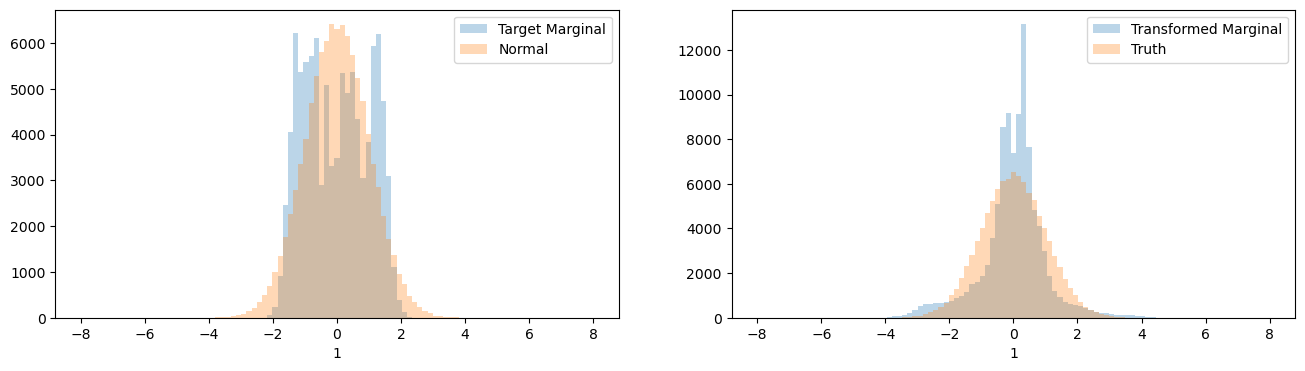

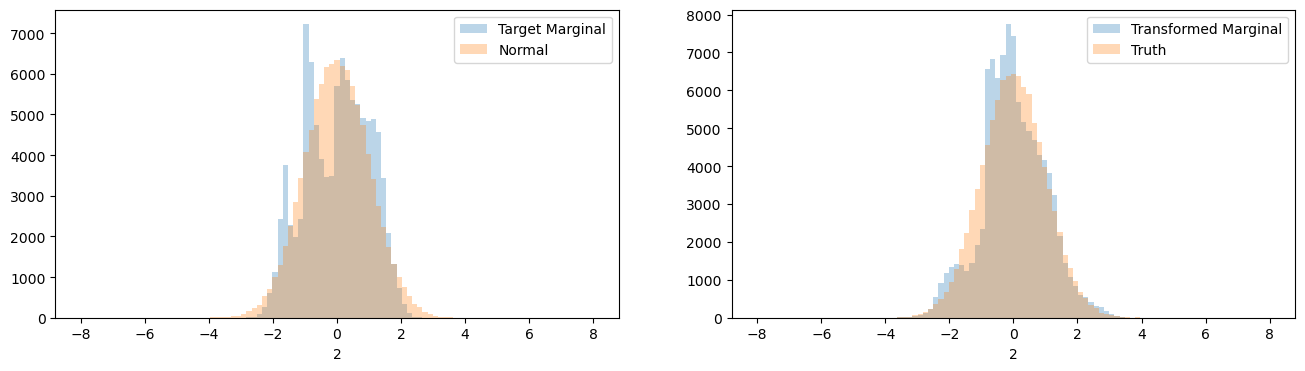

In [49]:


for i in 1:size(cpu(smpls_flat),1)
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    bins = range(-8, 8, 100)
    ax[1].hist(cpu(smpls_flat)[i,:], weights=smpls1_dsv.weight, bins=bins, alpha=0.3, label="Target Marginal")
    ax[1].hist(rand(Normal(), n_smpls),  bins=bins, alpha=0.3, label="Normal")
    ax[1].legend()
    ax[1].set_xlabel("$i")
    ax[2].hist(cpu(smpls_transformed)[i,:], weights=smpls1_dsv.weight, bins=bins, alpha=0.3, label="Transformed Marginal")
    ax[2].hist(rand(Normal(), n_smpls),  bins=bins, alpha=0.3, label="Truth")
    ax[2].legend()
    ax[2].set_xlabel("$i")
end

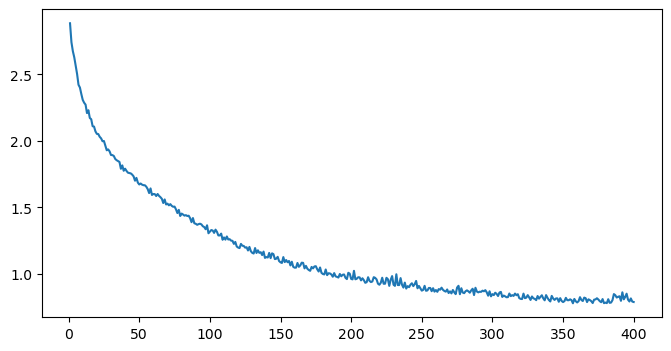

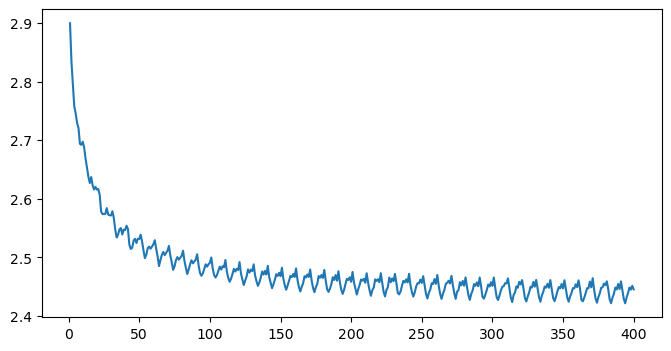

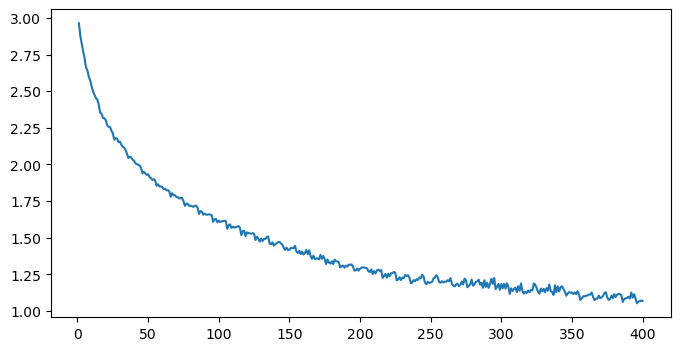

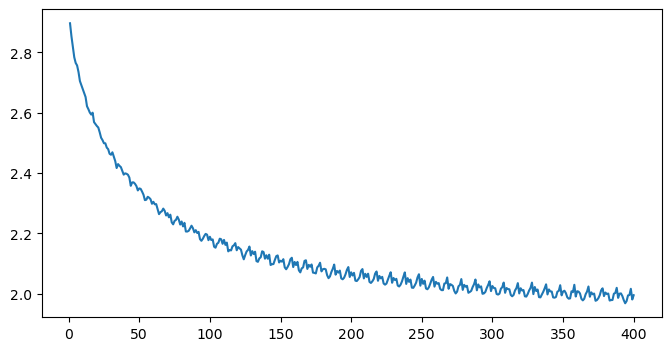

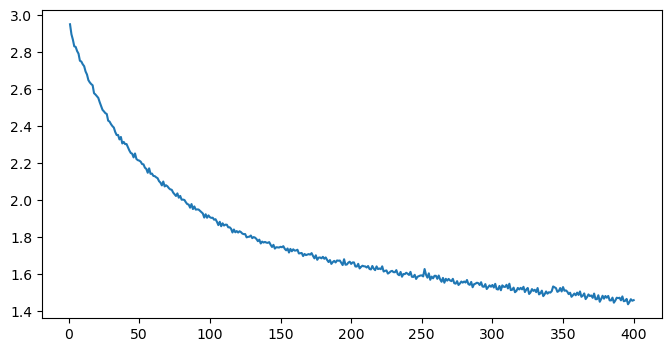

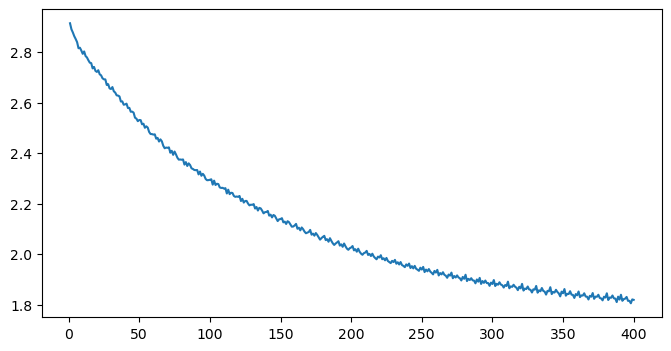

In [22]:
for i in 1:length(hists)
    fig2, ax2 = plt.subplots(1, figsize=(8,4))
    ax2.plot(1:length(hists[i]), hists[i])
end



In [ ]:
smpls_transformed, ladj2 = EuclidianNormalizingFlows.with_logabsdet_jacobian(trained_flow, gpu(smpls_flat))

smpls_transformed = cpu(smpls_transformed)
smpls_flat = cpu(smpls_flat)
ladj2 = cpu(ladj2)

ladj_trafo = cpu(ladj1) + ladj2

log_posterior = cpu(smpls1_dsv.logd) - vec(ladj_trafo)
frac = [logpdf(importance_density, smpls_transformed[:,i]) / log_posterior[i] for i in 1:n_smpls]

integral = n_smpls * inv(sum(frac)) 

variance = sqrt(integral^2/n_smpls * var(frac))

@show integral
@show variance
#parameters

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[1].hist2d(smpls_flat[1,:], smpls_flat[2,:], [100,100], cmap="inferno")
ax[1].set_xlim([-3, 3])
ax[1].set_ylim([-3, 3])
ax[2].hist2d(smpls_transformed[1,:], smpls_transformed[2,:], [100,100], cmap="inferno")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

In [ ]:
save("musketeer_handtrained.jld2", 
    Dict(
    "flow" => nd_trained_blocks,
    "samples" => cpu(smpls1_dsv),
       "ladj1" =>ladj1 )
)